In [10]:
import nn
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from tqdm import tqdm
from tensor.tensor import Tensor
from nn.optim import SGD
import matplotlib.pyplot as plt

In [2]:
def log_softmax(x):
    y = x - x.max()
    return y - y.exp().sum().log()


def cross_entropy_loss(x, y):
    return (-log_softmax(x) * y).sum()


In [3]:
class MyMNISTNet(nn.Module):
    def __init__(self):
        self.layer1 = nn.Linear2(28 * 28, 512)
        self.layer2 = nn.Linear2(512, 512)
        self.layer3 = nn.Linear2(512, 10)

    def forward(self, x):
        x.data = x.data.reshape(-1,28*28)
        x = self.layer1(x).relu()
        #print("After layer 1: ",x.data)
        x = self.layer2(x).relu()
        x = self.layer3(x)
        return x
    def parameters(self):
        return np.hstack([self.layer1.parameters(),self.layer2.parameters(),self.layer3.parameters()])

  5%|▌         | 1/20 [00:11<03:43, 11.79s/it]

Epoch: 0 	Training Loss: 0.17649470269680023


 10%|█         | 2/20 [00:23<03:28, 11.59s/it]

Epoch: 1 	Training Loss: 0.1722376048564911


 15%|█▌        | 3/20 [00:34<03:16, 11.57s/it]

Epoch: 2 	Training Loss: 0.15997515618801117


 20%|██        | 4/20 [00:46<03:07, 11.70s/it]

Epoch: 3 	Training Loss: 0.13192979991436005


 25%|██▌       | 5/20 [00:58<02:56, 11.77s/it]

Epoch: 4 	Training Loss: 0.12137287855148315


 30%|███       | 6/20 [01:10<02:47, 11.95s/it]

Epoch: 5 	Training Loss: 0.11784330010414124


 35%|███▌      | 7/20 [01:23<02:37, 12.08s/it]

Epoch: 6 	Training Loss: 0.11564641445875168


 40%|████      | 8/20 [01:35<02:25, 12.11s/it]

Epoch: 7 	Training Loss: 0.1139993742108345


 45%|████▌     | 9/20 [01:47<02:12, 12.08s/it]

Epoch: 8 	Training Loss: 0.11293067783117294


 50%|█████     | 10/20 [01:59<02:00, 12.03s/it]

Epoch: 9 	Training Loss: 0.11206851899623871


 55%|█████▌    | 11/20 [02:11<01:48, 12.02s/it]

Epoch: 10 	Training Loss: 0.11132684350013733


 60%|██████    | 12/20 [02:23<01:36, 12.03s/it]

Epoch: 11 	Training Loss: 0.110770083963871


 65%|██████▌   | 13/20 [02:35<01:24, 12.00s/it]

Epoch: 12 	Training Loss: 0.1103709489107132


 70%|███████   | 14/20 [02:47<01:11, 11.98s/it]

Epoch: 13 	Training Loss: 0.10992290079593658


 75%|███████▌  | 15/20 [02:59<00:59, 12.00s/it]

Epoch: 14 	Training Loss: 0.10968145728111267


 80%|████████  | 16/20 [03:11<00:47, 11.99s/it]

Epoch: 15 	Training Loss: 0.10940741002559662


 85%|████████▌ | 17/20 [03:23<00:36, 12.06s/it]

Epoch: 16 	Training Loss: 0.10926482826471329


 90%|█████████ | 18/20 [03:35<00:23, 12.00s/it]

Epoch: 17 	Training Loss: 0.10912215709686279


 95%|█████████▌| 19/20 [03:47<00:11, 11.98s/it]

Epoch: 18 	Training Loss: 0.10898548364639282


100%|██████████| 20/20 [03:59<00:00, 11.97s/it]

Epoch: 19 	Training Loss: 0.10889505594968796


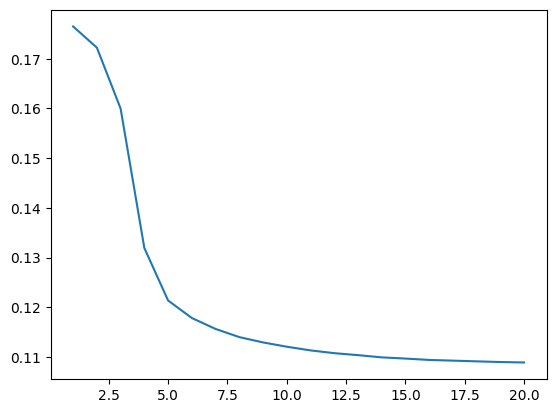

Accuracy: 0.8574833333333334


In [9]:
def get_randomized_batch(inputs,results,batch_size):
    randomized_indices = list(range(0, len(inputs), batch_size))
    np.random.shuffle(randomized_indices)
    for i in randomized_indices:
        yield inputs[i : i + batch_size], results[i : i + batch_size]


def torch_mine(test_loader, train_loader):
    model = MyMNISTNet()
    epochs = 20
    optim = SGD(model.parameters(),lr=0.005)
    losses = [0 for _ in range(epochs)]

    for i in tqdm(range(epochs)):
        train_loss = Tensor([0.0])
        inputs,results = train_loader.data.numpy(),train_loader.targets.numpy()
        dataiter = get_randomized_batch(inputs,results,32)
        for indx,(data, target) in enumerate(dataiter):
            data = Tensor(data.tolist())
            target = Tensor(target.tolist())
            optim.zero_grad()
            output = model(data)
            one_hot_target = np.array([np.eye(10)[int(target_elem)-1] for target_elem in target.data])
            loss = cross_entropy_loss(output,Tensor(one_hot_target)).sum() / output.data.shape[0]
            loss.backward()
            optim.step_tensor()
            train_loss += loss.sum().data[0]

        train_loss = train_loss / inputs.shape[0]
        losses[i] = train_loss.data[0]

        print(f"Epoch: {i} \tTraining Loss: {train_loss.data[0]}")

    plt.plot(range(1,epochs+1),losses)
    plt.show()

    test_inputs,test_results = test_loader.data.numpy(),test_loader.targets.numpy()
    true_cases = 0
    for (input,output) in zip(test_inputs,test_results):
        # use batching to make this faster
        input = Tensor(input.tolist())
        output = Tensor(output.tolist())
        model_out = model(input)
        if (np.argmax(model_out.data)+1) == output.data[0]:
            true_cases += 1
    print(f"Accuracy: {true_cases/len(test_inputs)}")






transform = transforms.ToTensor()
train_data = datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)
test_data = datasets.MNIST(
    root="data", train=False, download=True, transform=transform
)
torch_mine(train_data, test_data)